In [34]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from datetime import datetime
import numpy as np
import timeit
import json
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import itertools




In [30]:
def plot_confusion_matrix(cm, classes,
   x                       normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
main_df = pd.read_csv('main_df.csv')

In [17]:
main_df.head(1)

,project_id,outcome_state,final_usd_pledged,final_backers_count,project_name,project_description,live_state,in_mid_duration_range,usd_goal,usd_pledged,currency,launched_at,deadline,staff_pick,country,main_category,duration,days_from_launch,backers_count,project_link,creator_link,pledged_to_goal_ratio,description_len
0,464921389,successful,5660.0,40,Good Fishermen Know A Lot About Sex,A musical dramedy about family and dealing wit...,live,True,5000.0,1575.0,USD,08-21-2019,10-11-2019,False,US,Theater,50,21,24,https://www.kickstarter.com/projects/213094288...,https://www.kickstarter.com/profile/2130942887,0.315,58


In [18]:
model_cols = ['usd_goal', 'pledged_to_goal_ratio', 'duration', 'staff_pick',
              'country', 'main_category', 'backers_count', 'description_len', 'outcome_state']
continuous_cols = ['usd_goal', 'duration', 'backers_count', 'pledged_to_goal_ratio', 'description_len']
categorical_cols = ['staff_pick', 'country', 'main_category']

drop_cols = list(set(main_df.columns.to_list()) - set(model_cols))

In [19]:
# create model_df 
model_df = main_df.drop(drop_cols, axis=1)
model_df.head(1)

,outcome_state,usd_goal,staff_pick,country,main_category,duration,backers_count,pledged_to_goal_ratio,description_len
0,successful,5000.0,False,US,Theater,50,24,0.315,58


In [20]:
# encoding binary variables 
model_df['outcome_state'] = model_df['outcome_state'].map({'successful': 1, 'failed': 0})
model_df['staff_pick'] = model_df['staff_pick'].astype(int)


In [21]:
model_df.head(3)

,outcome_state,usd_goal,staff_pick,country,main_category,duration,backers_count,pledged_to_goal_ratio,description_len
0,1,5000.0,0,US,Theater,50,24,0.31500,58
1,0,1000.0,0,US,Crafts,45,2,0.00600,117
2,0,25000.0,0,US,Film & Video,45,2,0.00008,78


In [22]:
# Function to dummy categorical variables
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [23]:
dummy_model_df = dummy_df(model_df, ['country', 'main_category'])

X = dummy_model_df.drop('outcome_state', axis=1)
y = dummy_model_df.loc[:, 'outcome_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=60)

In [24]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##  XGBooster

In [46]:
# Instantiate XGBClassifier
xgboost = XGBClassifier()

# Fit XGBClassifier
xgboost.fit(X_train, y_train)

# Predict on training and test sets
training_preds = xgboost.predict(X_train)
test_preds = xgboost.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {}'.format(training_accuracy))
print('Validation accuracy: {}'.format(test_accuracy))

Training Accuracy: 0.9630408653846154
Validation accuracy: 0.9519807923169268


In [48]:
# Confusion matrix metrics
print(f"Precision Score (Test): {precision_score(y_test, test_preds)}")
print(f"Recall Score (Test): {recall_score(y_test, test_preds)}")
print(f"F1 Score (Test): {f1_score(y_test, test_preds)}")
print(f"accuracy Score (Test): {accuracy_score(y_test, test_preds)}")



Precision Score (Test): 0.9595070422535211
Recall Score (Test): 0.9697508896797153
F1 Score (Test): 0.9646017699115045
accuracy Score (Test): 0.9519807923169268


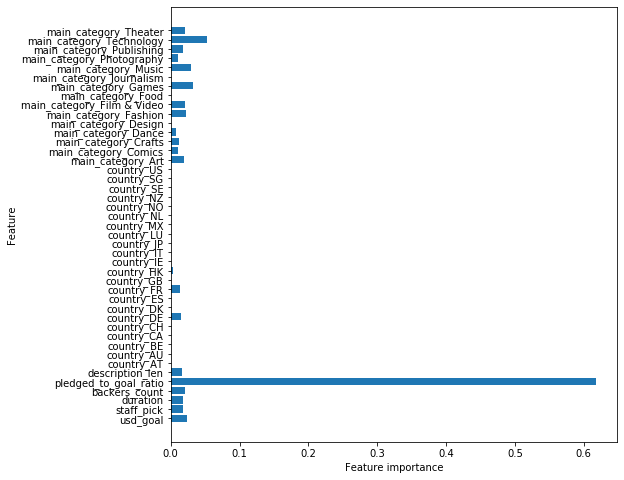

In [33]:
plot_feature_importances(xgboost)

In [37]:
confusion = confusion_matrix(y_test,test_preds)
classes = ['Failed', 'Succeded']

[[248  23]
 [ 17 545]]


Confusion Matrix, without normalization
[[248  23]
 [ 17 545]]


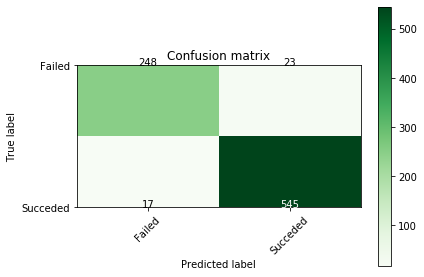

In [43]:
plot_confusion_matrix(confusion, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens)

In [27]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, training_preds))

[[248  23]
 [ 17 545]]


ValueError: Found input variables with inconsistent numbers of samples: [833, 3328]

In [41]:
print(confusion_matrix(y_test, gradient_test_preds))
print(classification_report(y_test, gradient_test_preds))
print(f"Precision Score (Test): {precision_score(y_test, gradient_test_preds)}")
print(f"Precision Score (Train): {precision_score(y_train, gradient_train_preds)}")
print(f"Recall Score (Test): {recall_score(y_test, gradient_test_preds)}")
print(f"Recall Score (Train): {recall_score(y_train, gradient_train_preds)}")

[[245  26]
 [ 16 546]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       271
           1       0.95      0.97      0.96       562

    accuracy                           0.95       833
   macro avg       0.95      0.94      0.94       833
weighted avg       0.95      0.95      0.95       833

Precision Score (Test): 0.9545454545454546
Precision Score (Train): 0.9702276707530648
Recall Score (Test): 0.9715302491103203
Recall Score (Train): 0.9822695035460993


In [30]:
def plot_confusion_matrix(cm, classes,
   x                       normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print(metrics.precision_score(y_test, y_pred_class))

In [32]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gradient_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gradient_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.9549278846153846
F1-Score: 0.9669603524229075

Model: Gradient Boosted Trees
Accuracy: 0.9675480769230769
F1-Score: 0.9762114537444935

Testing Metrics
Model: AdaBoost
Accuracy: 0.9423769507803121
F1-Score: 0.9575971731448762

Model: Gradient Boosted Trees
Accuracy: 0.9495798319327731
F1-Score: 0.9629629629629629


In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

forest_grid_search = GridSearchCV(forest_grid_search, dt_param_grid, cv=3, return_train_score=True)
